# Convolution base model (from input to last convolutional layer)

Our device can only accelerate models that are in int8. 
But gradCam likely requires saving our model in float.

To get over this problem, we can use 2 models, one that does the convolutional operation (accelarated), and one that does the classification and GradCam (not accelarated).

Here I am taking the convolutional layers of a ResNet50 as an example of a the convolutional network.

In [2]:
import tensorflow as tf
print(tf.__version__)
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

2024-04-15 10:01:57.380882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 10:01:57.677989: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kevin/catkin_ws/devel/lib:/opt/ros/noetic/lib
2024-04-15 10:01:57.678012: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-15 10:01:58.584464: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer

2.11.0


We use a small dataset that can be used to quantize the convolutional network.

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(PATH)

/home/kevin/.keras/datasets/cats_and_dogs_filtered


In [7]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


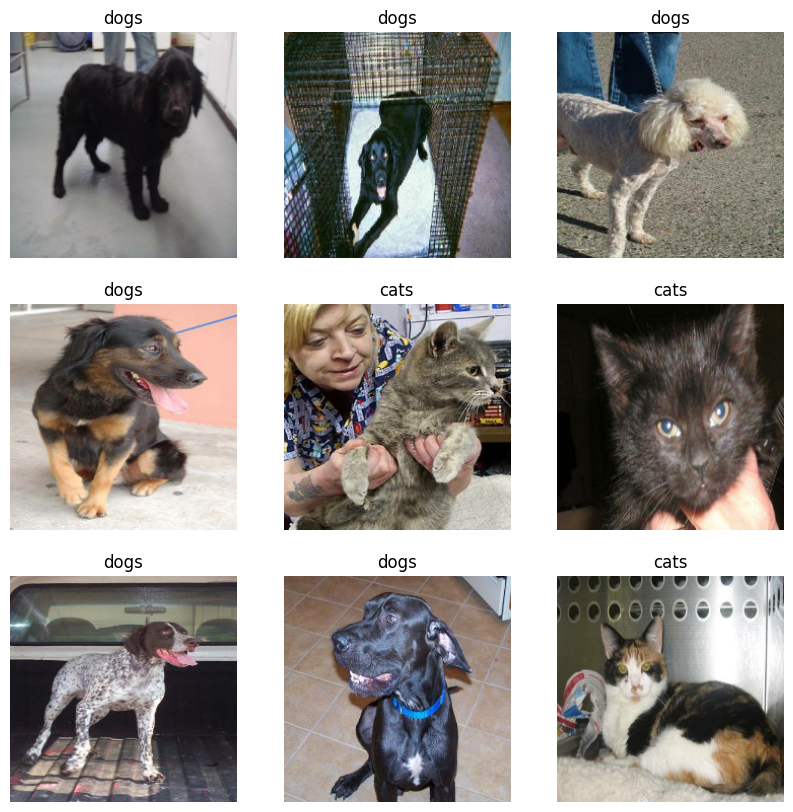

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
print("Number of batches in validation set:", val_batches)
print(val_batches // 5)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Number of batches in validation set: tf.Tensor(26, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
(32, 224, 224, 3) (32,)


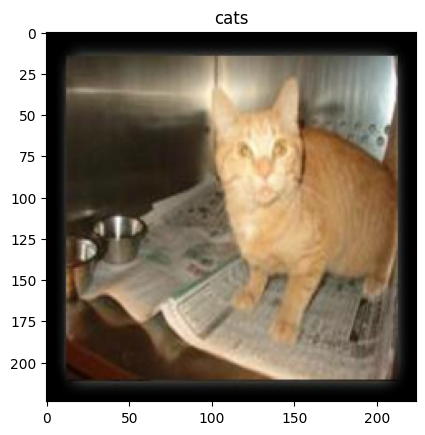

(array([19110.,  4804.,  7172.,  6806.,  8238.,  6680.,  4472.,  4233.,
         4198.,  4933.,  5867.,  6178.,  6247.,  6607.,  6731.,  6772.,
         6281.,  5469.,  4705.,  4149.,  3692.,  3295.,  2901.,  2253.,
         1879.,  1726.,  1713.,  1472.,  1081.,   864.]),
 array([  0. ,   8.5,  17. ,  25.5,  34. ,  42.5,  51. ,  59.5,  68. ,
         76.5,  85. ,  93.5, 102. , 110.5, 119. , 127.5, 136. , 144.5,
        153. , 161.5, 170. , 178.5, 187. , 195.5, 204. , 212.5, 221. ,
        229.5, 238. , 246.5, 255. ], dtype=float32),
 <BarContainer object of 30 artists>)

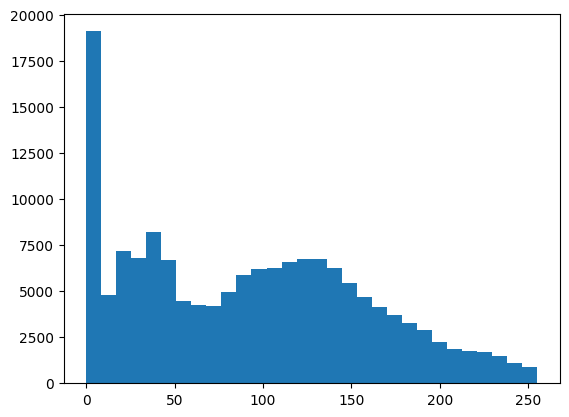

In [33]:
# get one image from the training dataset
images, labels = next(iter(train_dataset))
print(type(images))
# get the datatype of the image
print(images.dtype)
print(images.shape, labels.shape)
image = images[0].numpy().astype("uint8").copy()
plt.imshow(image)
plt.title(class_names[labels[0]])
plt.show()

plt.hist(images[0].numpy().flatten(), bins=30)


In [13]:
%run imagenet1000_clsidx_to_labels.py

In [14]:
imagenet_labels[0]

'tench, Tinca tinca'

## Create our model


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import (
    ResNet50,
    preprocess_input,
    decode_predictions,
)

In [16]:
model = ResNet50()

(224, 224, 3) (32,)


Text(0.5, 1.0, 'cats')

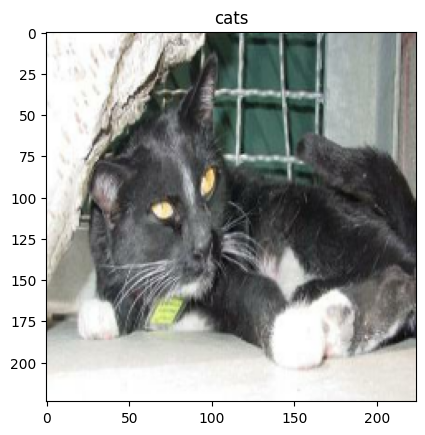

In [49]:
# get one image from the training dataset
images, labels = next(iter(train_dataset))
print(image.shape, labels.shape)
image = images[0].numpy().astype("uint8").copy()
plt.imshow(image)
plt.title(class_names[labels[0]],)

In [50]:
res = model(image[np.newaxis, ...])
# get the top result
maxIndex = np.argmax(res)
print(maxIndex, res[0,maxIndex], imagenet_labels[maxIndex])

281 tf.Tensor(0.41561884, shape=(), dtype=float32) tabby, tabby cat


We will save the entire ResNet50 so that we can use it for TF Lite inference.

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Save the model.
with open('resnet50_model.tflite', 'wb') as f:
  f.write(tflite_model)

We can also optimize our model with the default parameters. This quantiize all fixed parameters.

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp5ss6pqro/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ss6pqro/assets
2024-04-15 10:10:05.198577: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-04-15 10:10:05.198599: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-04-15 10:10:05.198751: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5ss6pqro
2024-04-15 10:10:05.235829: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-04-15 10:10:05.235857: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5ss6pqro
2024-04-15 10:10:05.340996: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-04-15 10:10:05.809529: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5ss6pqro
2024-04-15 10:10:05.950710: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [ ]:
# Save the model.
with open('resnet50_model_optim_default.tflite', 'wb') as f:
  f.write(tflite_model)

Save imagenet labels for our c++ program.

In [58]:
# save the imagenet labels to a text file, one label per line
with open('imagenet_labels.txt', 'w') as f:
  for k in imagenet_labels:
    f.write(imagenet_labels[k] + '\n')

### Compare TF and TFLite models

We use an image from a file so that we can do the same in c++

In [59]:
# load image from file with openCV
image = cv2.imread('../data/cat.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))


In [62]:
# Function to print the 5 best results from the model output 
def print_best_results(res):
  for i in range(5):
    maxIndex = np.argmax(res)
    print(imagenet_labels[maxIndex], res[0,maxIndex])
    res[0,maxIndex] = 0  

In [63]:
# run inference with the TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

# run inference
input_shape = input_details[0]['shape']
input_data = image[np.newaxis, ...].astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print_best_results(output_data)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 186, 'shape': array([   1, 1000], dtype=int32), 'shape_signature': array([  -1, 1000], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
lynx, catamount 0.26259804
tabby, tabby cat 0.26225066
tiger cat 0.18247962
Egyptian cat 0.14881156
snow leopard, ounce, Panthera uncia 0.011447397


In [65]:
res = model(image[np.newaxis, ...])
# get the top result
print_best_results(res.numpy())

tabby, tabby cat 0.26540586
lynx, catamount 0.25243485
tiger cat 0.20394175
Egyptian cat 0.14051764
snow leopard, ounce, Panthera uncia 0.011604635


To run similar inference with the c++ program

```
cd ~/repo/tfl_inference_classification/build
./inference_classification ../python/resnet50_model_optim_default.tflite ../data/cat.jpg  -l ../python/imagenet_labels.txt 
```